In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from copy import copy
from scipy.ndimage import gaussian_filter1d
from scipy.signal import medfilt
import utils2p

In [2]:
base_dir = "/home/jbraun/bin/deepinterpolation/sample_data"

raw_path_210301 = os.path.join(base_dir, "210301_001_crop.tif")
raw_path_210301_8Hz = os.path.join(base_dir, "210301_001_crop_8Hz.tif")
raw_path_longterm = os.path.join(base_dir, "longterm_003_crop.tif")
raw_path_R57C10_GCaMP6s_8Hz = os.path.join(base_dir, "R57C10_GCaMP6s_8Hz_crop.tif")
raw_path_ABO_GCaMP6s_16Hz = os.path.join(base_dir, "ABO_GCaMP6s_16Hz_crop.tif")

denoised_path_210301 = os.path.join(base_dir, "denoised_random1_01_2000_210301_001_crop_out.tif")
denoised_path_210301_8_Hz = os.path.join(base_dir, "comp_denoise_210301_001_crop_8Hz.tif")
denoised_path_longterm = os.path.join(base_dir, "comp_denoise_longterm_003_crop.tif")
denoised_path_R57C10_GCaMP6s_8Hz = os.path.join(base_dir, "comp_denoise_R57C10_GCaMP6s_8Hz_crop.tif")
denoised_path_ABO_GCaMP6s_8Hz = os.path.join(base_dir, "comp_denoise_ABO_GCaMP6s_16Hz_crop.tif")
denoised_path_FA_ABO_GCaMP6s_8Hz = os.path.join(base_dir, "comp_denoiseFA_ABO_GCaMP6s_16Hz.tif")

raw_paths = [
    raw_path_210301,
    raw_path_210301_8Hz,
    raw_path_longterm,
    raw_path_R57C10_GCaMP6s_8Hz,
    raw_path_ABO_GCaMP6s_16Hz,
    raw_path_ABO_GCaMP6s_16Hz
]

denoised_paths = [
    denoised_path_210301,
    denoised_path_210301_8_Hz,
    denoised_path_longterm,
    denoised_path_R57C10_GCaMP6s_8Hz,
    denoised_path_ABO_GCaMP6s_8Hz,
    denoised_path_FA_ABO_GCaMP6s_8Hz  
]

strings = [
    "JB R57C10 GCaMP6f 16 Hz",
    "JB R57C10 GCaMP6f  8 Hz",
    "LH R57C10 GCaMP6f  8 Hz",
    "FA R57C10 GCaMP6s  8 Hz",
    "FA    ABO GCaMP6s 16 Hz",
    "FA    ABO GCaMP6s 16 Hz FAdenoise",
]
f_s = [16, 8, 8, 8, 16, 16]

In [3]:
raw = [utils2p.load_img(raw_path)[30:-30,:,:] for raw_path in raw_paths]
denoised = [utils2p.load_img(denoised_path) for denoised_path in denoised_paths]

In [4]:
from copy import deepcopy
# crop parameters for FA denoise: height offset 168, height 240, width offset 26, width 688
# adapt his deonising output to my shape
tmp = deepcopy(denoised[5])
denoised[5] = np.zeros_like(raw[5])
denoised[5][:, 88:, :] = tmp[:, :-8, 6:-10]
# print(raw[5].shape, denoised[5].shape, (4040, 480, 736))
# print("80:-80, 32:-32 | 168:168+240=-72, 26:26+688=-22",)

In [5]:
tmp = np.vstack((np.zeros((1, ) + denoised[1].shape[1:]),
                 denoised[1],
                 np.zeros((1, ) + denoised[1].shape[1:])))

denoised[1] = tmp
assert len(denoised[1]) == len(raw[1])

In [6]:
tmp = np.vstack((np.zeros((1, ) + denoised[3].shape[1:]),
                 denoised[3],
                 np.zeros((1, ) + denoised[3].shape[1:])))

denoised[3] = tmp
assert len(denoised[3]) == len(raw[1])

## check what the denoising did

In [7]:
std_raw = [np.std(r, axis=0)for r in raw]
std_denoised = [np.std(d, axis=0)for d in denoised]

In [13]:
pixels_210301 = [[174, 97], [91, 172], [171, 280], [122, 443], [185, 575]]
# left bottom, left top, center, top right dim, bottom right
pixels_noise_210301 = [[50, 50], [129, 272]]
# outside, giant fiber

pixels_longterm = [[113, 50], [73, 324], [165, 102], [162, 274], [201, 471]]
pixels_noise_longterm = [[50,50], [120, 260]]

pixels_FA_R57C10 = [[135, 130], [218, 216], [215, 528], [232, 412], [137, 544]]
pixels_noise_FA_R57C10 = [[50, 50], [110, 300]]

pixels_FA_ABO = [[142, 102], [147, 575], [174, 263], [215, 313], [187, 648]]
pixels_noise_FA_ABO = [[110, 50], [147, 300]]

pixels = [
    pixels_210301,
    pixels_210301,
    pixels_longterm,
    pixels_FA_R57C10,
    pixels_FA_ABO,
    pixels_FA_ABO
]
pixels_noise = [
    pixels_noise_210301,
    pixels_noise_210301,
    pixels_noise_longterm,
    pixels_noise_FA_R57C10,
    pixels_noise_FA_ABO,
    pixels_noise_FA_ABO
]

<IPython.core.display.Javascript object>


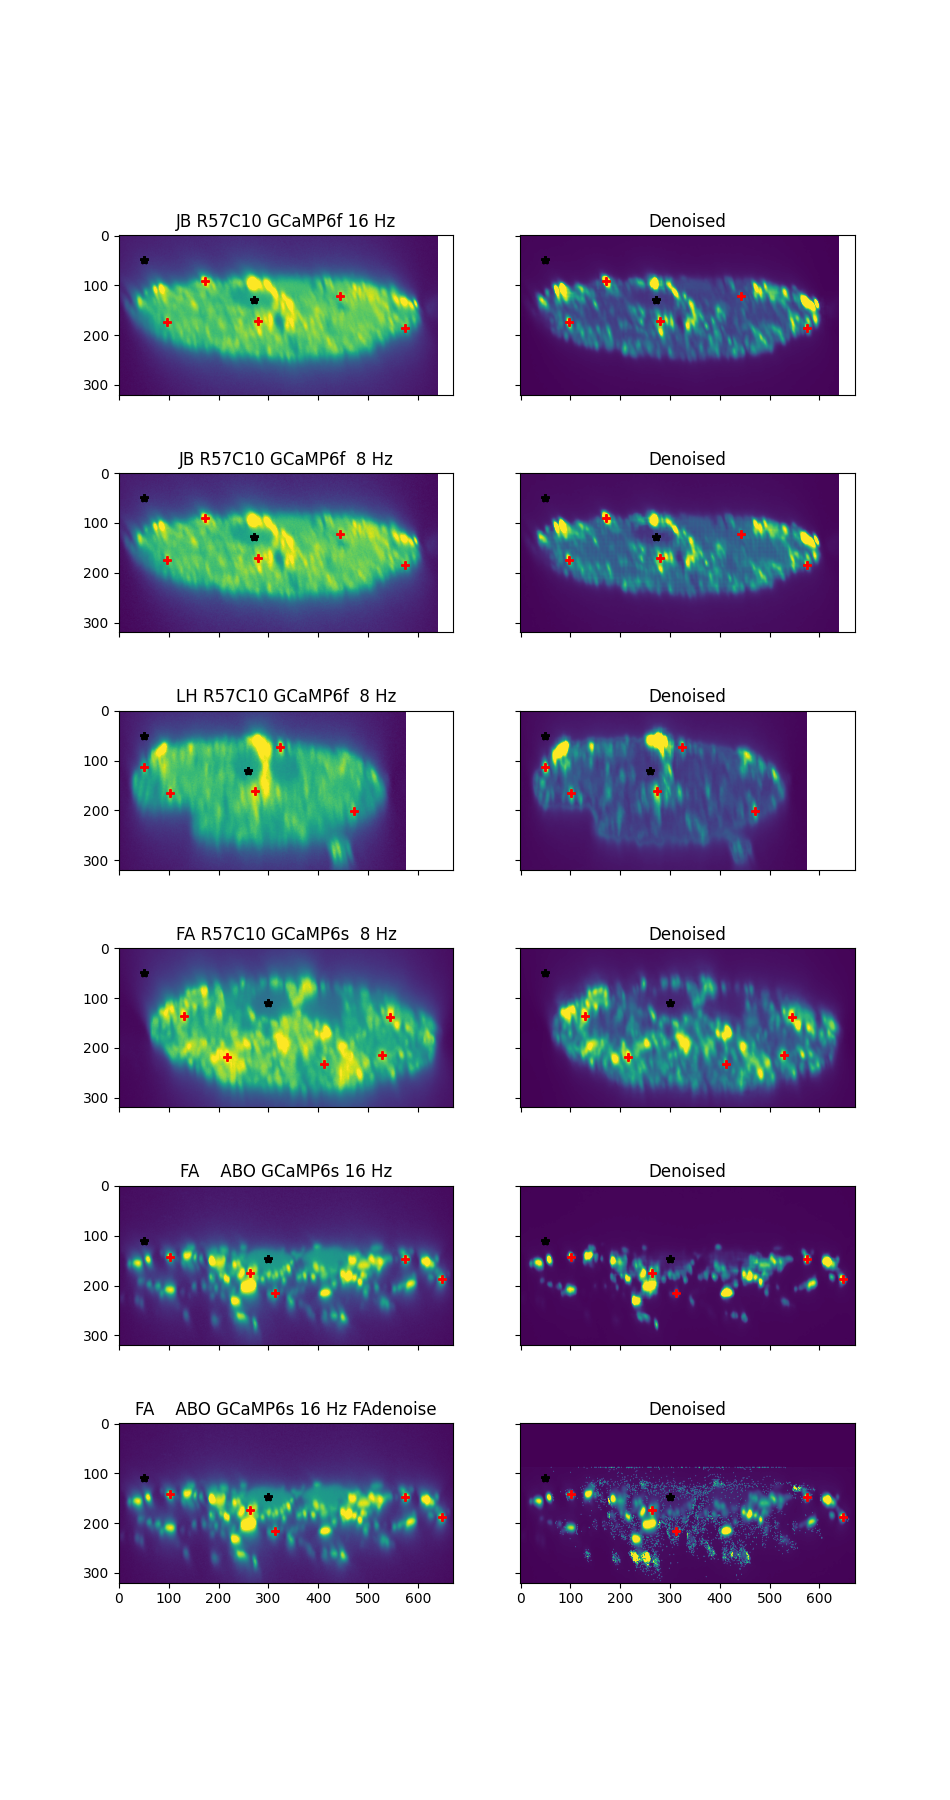

In [15]:
%matplotlib notebook
quantile = 0.99
fig, axs = plt.subplots(nrows=len(strings), ncols=2, figsize=(9.5, 18), sharex=True, sharey=True)  # "row", sharey="row")

for i_row, (ax_row, this_raw, this_denoised, string, p, p_n) \
    in enumerate(zip(axs, std_raw, std_denoised, strings, pixels, pixels_noise)):
    ax_row[0].imshow(this_raw, clim=[0, np.quantile(this_raw, quantile)])
    ax_row[1].imshow(this_denoised, clim=[0, np.quantile(this_denoised, quantile)])
    ax_row[0].set_title(string)
    ax_row[1].set_title("Denoised")

    _ = [[ax_row[0].plot(pixel[1], pixel[0], 'r+') for pixel in p] for ax in axs.flatten()]
    _ = [[ax_row[0].plot(pixel[1], pixel[0], 'k*') for pixel in p_n] for ax in axs.flatten()]
    _ = [[ax_row[1].plot(pixel[1], pixel[0], 'r+') for pixel in p] for ax in axs.flatten()]
    _ = [[ax_row[1].plot(pixel[1], pixel[0], 'k*') for pixel in p_n] for ax in axs.flatten()]


## plot one individual dataset

<IPython.core.display.Javascript object>


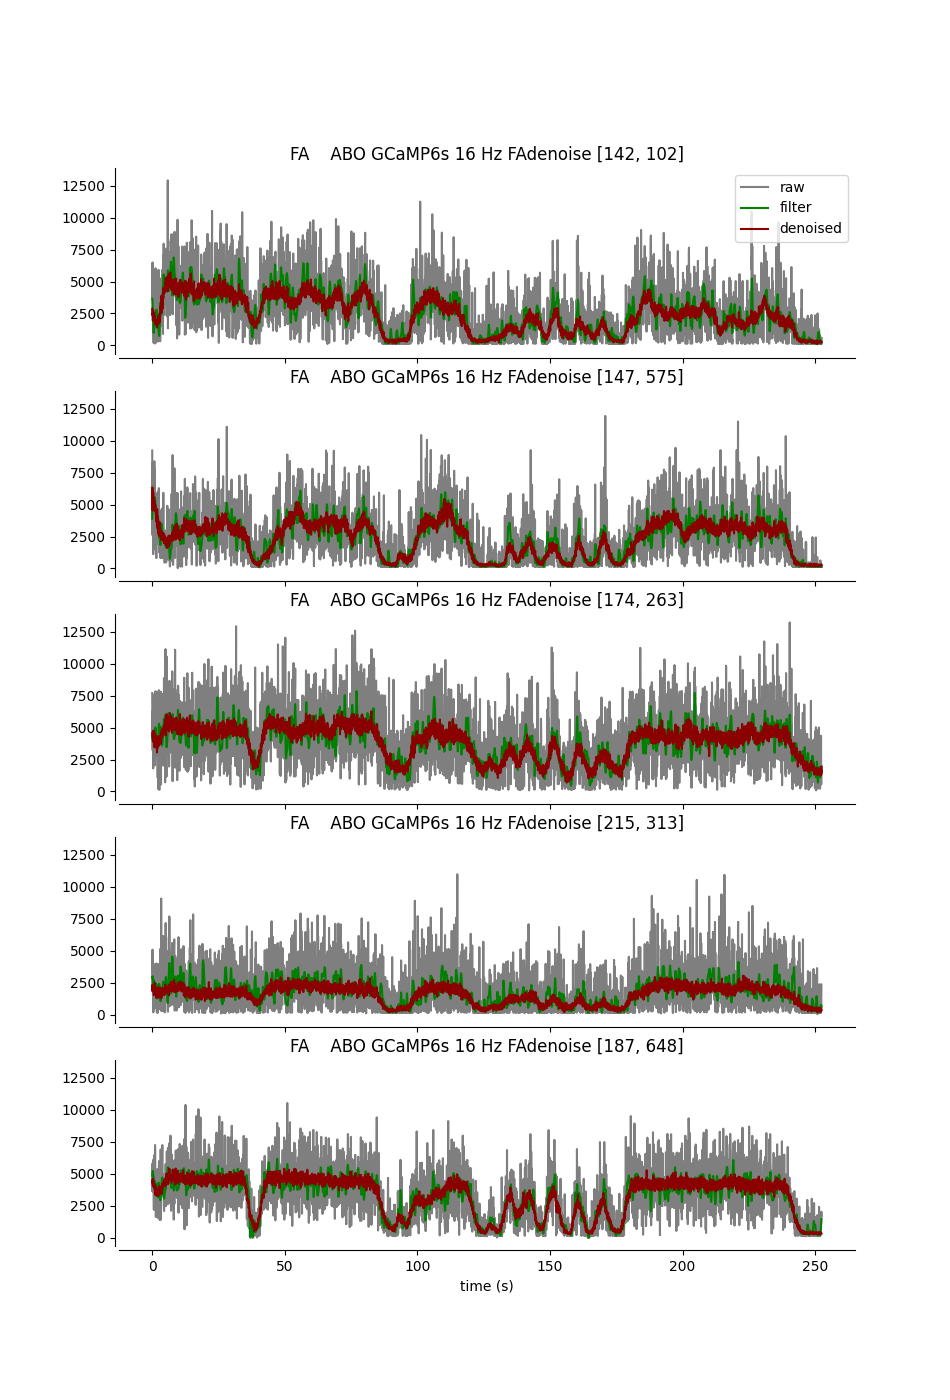

Text(0.5, 0, 'time (s)')

In [82]:
%matplotlib notebook

i_signal = 5

x = np.arange(len(raw[i_signal])) / f_s[i_signal]
alpha = 1
spine_outward_shift=3

fig, axs = plt.subplots(ncols=1, nrows=5, figsize=(9.5, 14), sharex=True, sharey=True)
for i_ax, (ax, pixel) in enumerate(zip(axs, pixels[i_signal])):
    this_raw = raw[i_signal]
    this_denoised = denoised[i_signal]
    ax.plot(x, this_raw[:, pixel[0], pixel[1]], 'k', label="raw", alpha=0.5)
    ax.plot(x, gaussian_filter1d(medfilt(this_raw[:, pixel[0], pixel[1]], [5]), sigma=2), 'g', label="filter")
    
    ax.plot(x, this_denoised[:, pixel[0], pixel[1]], color="darkred", alpha=alpha, label="denoised")


    ax.set_title(strings[i_signal] + " " + str(pixel))
    if i_ax == 0:
        ax.legend()
        
    ax.spines['left'].set_position(('outward', spine_outward_shift))  # ('axes', -0.02))  # 'zero'

    # turn off the right spine/ticks
    ax.spines['right'].set_color('none')
    ax.yaxis.tick_left()

    # set the y-spine
    ax.spines['bottom'].set_position(('outward', spine_outward_shift))  # ('axes', -0.02))  # 'zero'

    # turn off the top spine/ticks
    ax.spines['top'].set_color('none')
    ax.xaxis.tick_bottom()
        
ax.set_xlabel("time (s)")
    
# ax.set_xlim([0, 100]) 
# ax.set_ylim([0, 3000])

# compare Florian's denoising with my denoising

<IPython.core.display.Javascript object>


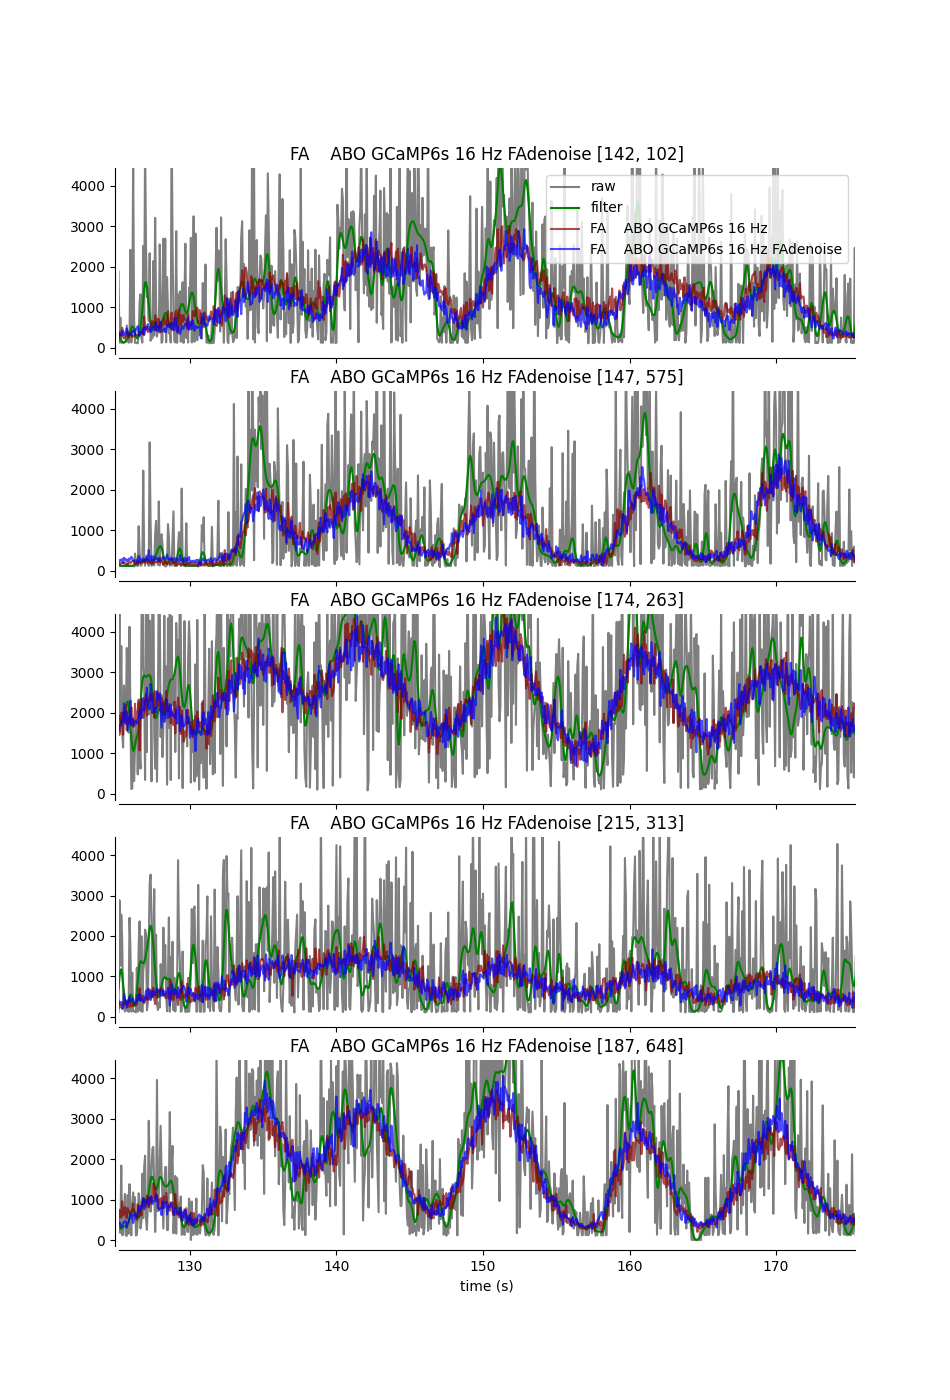

Text(0.5, 0, 'time (s)')

In [83]:
%matplotlib notebook

i_signals = [4,5]
colors = [None, None, None, None, "darkred", "blue"]

x = np.arange(len(raw[i_signals[0]])) / f_s[i_signals[0]]
alpha = 0.7
spine_outward_shift=3

fig, axs = plt.subplots(ncols=1, nrows=5, figsize=(9.5, 14), sharex=True, sharey=True)
for i_ax, (ax, pixel) in enumerate(zip(axs, pixels[i_signals[0]])):
    this_raw = raw[i_signals[0]]
    ax.plot(x, this_raw[:, pixel[0], pixel[1]], 'k', label="raw", alpha=0.5)
    ax.plot(x, gaussian_filter1d(medfilt(this_raw[:, pixel[0], pixel[1]], [5]), sigma=2), 'g', label="filter")
    
    for i_signal in i_signals:
        this_denoised = denoised[i_signal]
        this_legend = strings[i_signal]
        this_color = colors[i_signal]
        ax.plot(x, this_denoised[:, pixel[0], pixel[1]], color=this_color, alpha=alpha, label=this_legend)


    ax.set_title(strings[i_signal] + " " + str(pixel))
    if i_ax == 0:
        ax.legend()
        
    ax.spines['left'].set_position(('outward', spine_outward_shift))  # ('axes', -0.02))  # 'zero'

    # turn off the right spine/ticks
    ax.spines['right'].set_color('none')
    ax.yaxis.tick_left()

    # set the y-spine
    ax.spines['bottom'].set_position(('outward', spine_outward_shift))  # ('axes', -0.02))  # 'zero'

    # turn off the top spine/ticks
    ax.spines['top'].set_color('none')
    ax.xaxis.tick_bottom()
        
ax.set_xlabel("time (s)")
    
# ax.set_xlim([0, 100]) 
# ax.set_ylim([0, 2500])

# compare 8Hz vs 16 Hz denoising on JB data

<IPython.core.display.Javascript object>


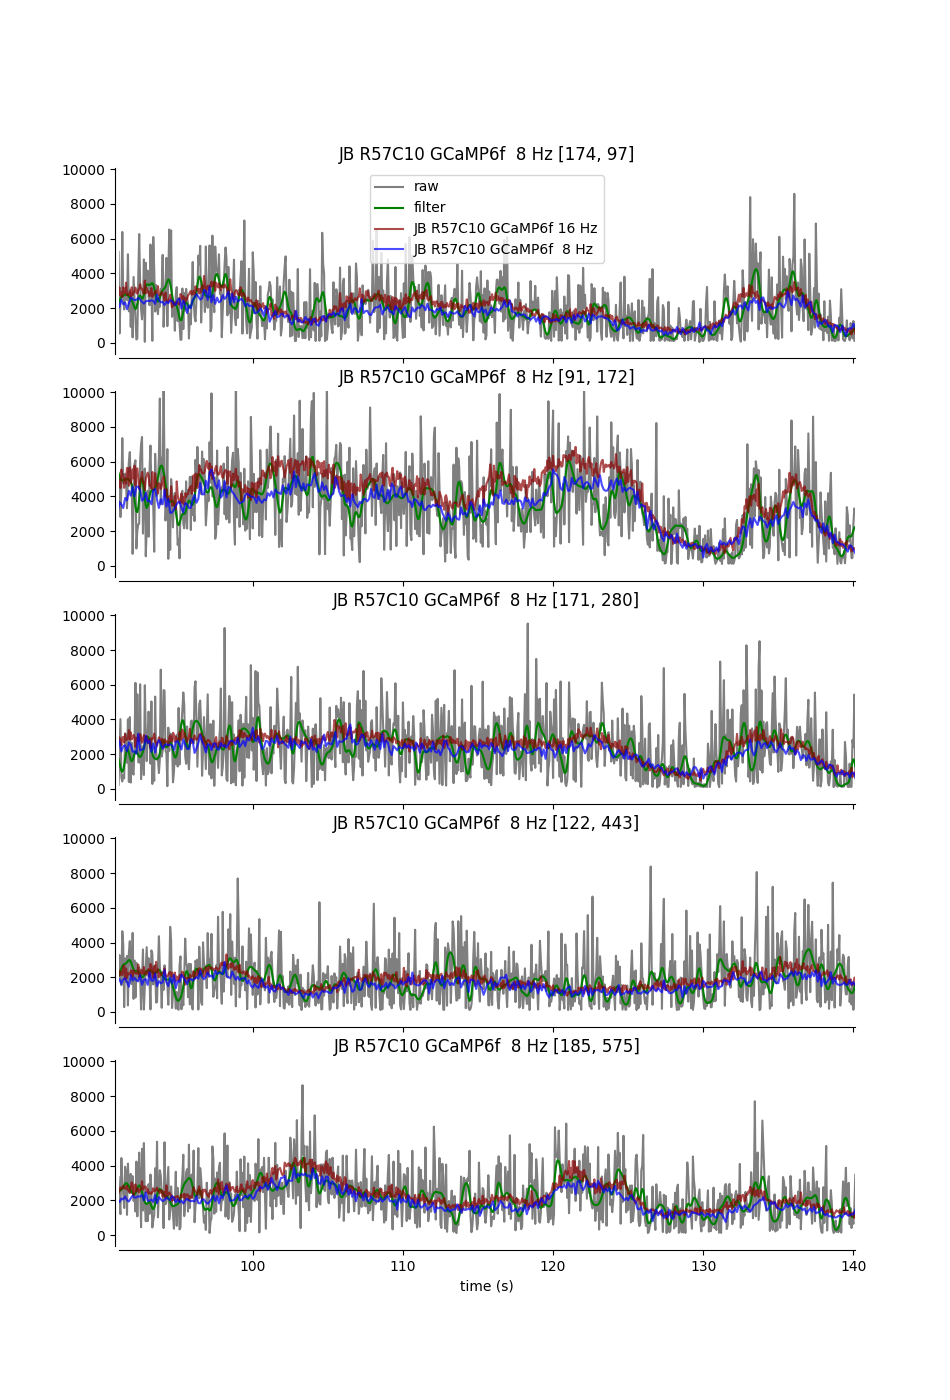

Text(0.5, 0, 'time (s)')

In [84]:
%matplotlib notebook

i_signals = [0, 1]
colors = ["darkred", "blue", None, None, "darkred", "blue"]


alpha = 0.7
spine_outward_shift=3

fig, axs = plt.subplots(ncols=1, nrows=5, figsize=(9.5, 14), sharex=True, sharey=True)
for i_ax, (ax, pixel) in enumerate(zip(axs, pixels[i_signals[0]])):
    for i_signal in i_signals:
        this_raw = raw[i_signal]
        
        if i_signal == 1:
            x = np.arange(len(this_raw)) / f_s[i_signal]
        else:
            # the -30 is because of the different cut-offs from the denoising. in both cases it is 30 samples
            x = np.arange(len(this_raw)) / f_s[i_signal] -30 / f_s[i_signal]
            ax.plot(x, this_raw[:, pixel[0], pixel[1]], 'k', label="raw", alpha=0.5)
            ax.plot(x, gaussian_filter1d(medfilt(this_raw[:, pixel[0], pixel[1]], [5]), sigma=2), 'g', label="filter")
        this_denoised = denoised[i_signal]
        this_legend = strings[i_signal]
        this_color = colors[i_signal]
        ax.plot(x, this_denoised[:, pixel[0], pixel[1]], color=this_color, alpha=alpha, label=this_legend)


    ax.set_title(strings[i_signal] + " " + str(pixel))
    if i_ax == 0:
        ax.legend()
        
    ax.spines['left'].set_position(('outward', spine_outward_shift))  # ('axes', -0.02))  # 'zero'

    # turn off the right spine/ticks
    ax.spines['right'].set_color('none')
    ax.yaxis.tick_left()

    # set the y-spine
    ax.spines['bottom'].set_position(('outward', spine_outward_shift))  # ('axes', -0.02))  # 'zero'

    # turn off the top spine/ticks
    ax.spines['top'].set_color('none')
    ax.xaxis.tick_bottom()
        
ax.set_xlabel("time (s)")
    
# ax.set_xlim([0, 100]) 
# ax.set_ylim([0, 2500])

In [39]:
i_signal

1

<IPython.core.display.Javascript object>


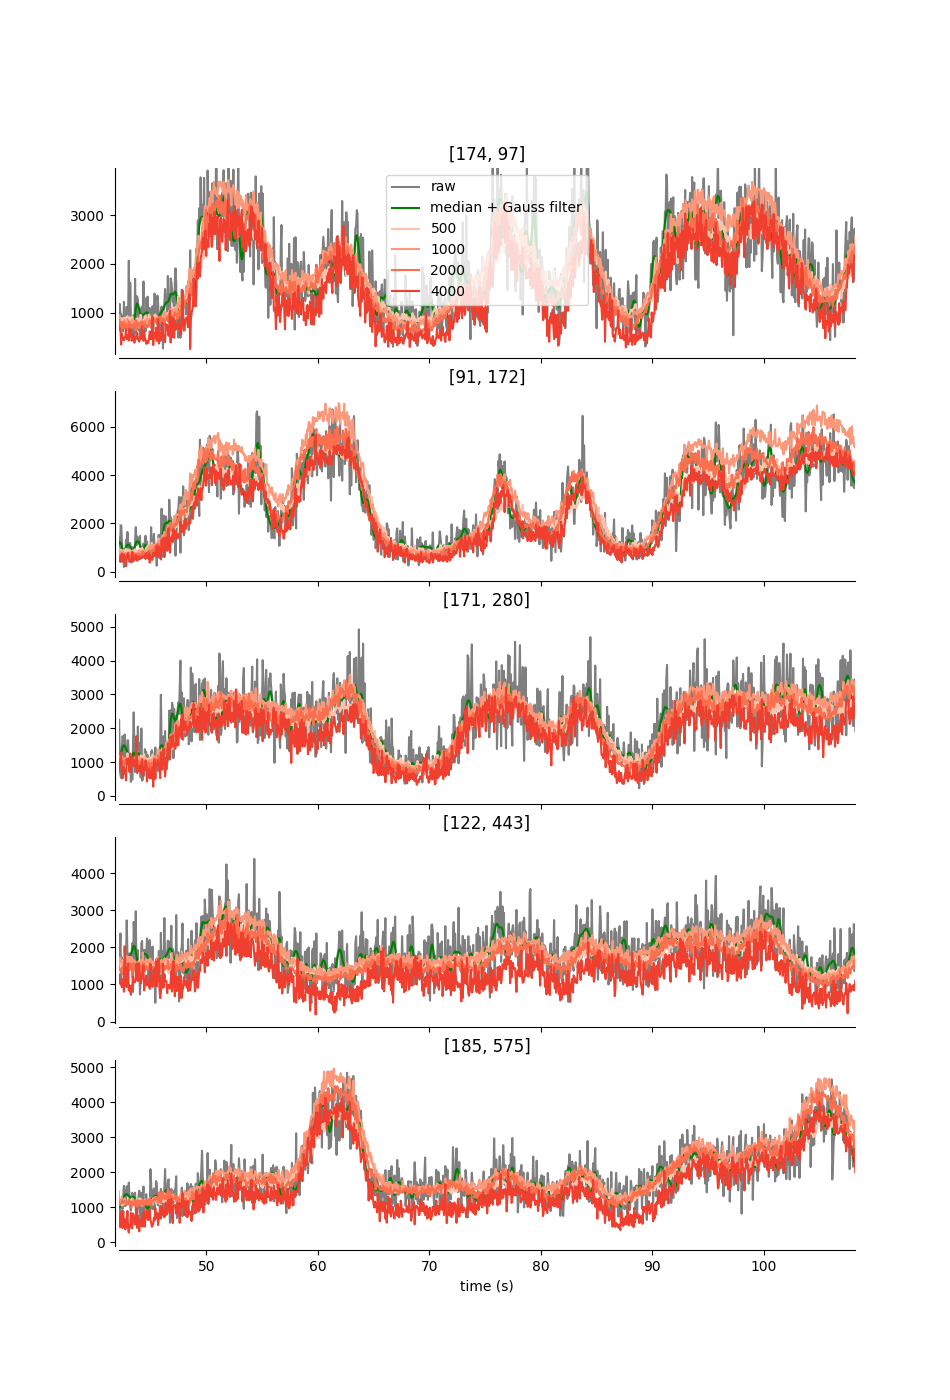

(0.9896501345636294, 0.7595078815840062, 0.6660361399461745, 1.0)
(0.9882352941176471, 0.5958785082660515, 0.4738023836985775, 1.0)
(0.9847443291041906, 0.4329104190695886, 0.3074202229911573, 1.0)
(0.9407612456747405, 0.24510572856593618, 0.18131487889273357, 1.0)
(0.9896501345636294, 0.7595078815840062, 0.6660361399461745, 1.0)
(0.9882352941176471, 0.5958785082660515, 0.4738023836985775, 1.0)
(0.9847443291041906, 0.4329104190695886, 0.3074202229911573, 1.0)
(0.9407612456747405, 0.24510572856593618, 0.18131487889273357, 1.0)
(0.9896501345636294, 0.7595078815840062, 0.6660361399461745, 1.0)
(0.9882352941176471, 0.5958785082660515, 0.4738023836985775, 1.0)
(0.9847443291041906, 0.4329104190695886, 0.3074202229911573, 1.0)
(0.9407612456747405, 0.24510572856593618, 0.18131487889273357, 1.0)
(0.9896501345636294, 0.7595078815840062, 0.6660361399461745, 1.0)
(0.9882352941176471, 0.5958785082660515, 0.4738023836985775, 1.0)
(0.9847443291041906, 0.4329104190695886, 0.3074202229911573, 1.0)
(0.9

Text(0.5, 0, 'time (s)')

In [30]:
%matplotlib notebook
roi_size = 2
alpha = 1

x = np.arange(4040) / 16

alpha = 1
spine_outward_shift=3

show_signal = [1, 1, 1, 1, 0, 0, 0]  # compare across trials [0, 0, 1, 0, 1, 0, 1]

fig, axs = plt.subplots(ncols=1, nrows=5, figsize=(9.5, 14), sharex=True, sharey=False)

for i_ax, (ax, pixel) in enumerate(zip(axs, pixels)):
    roi_signal = np.mean(raw[:, pixel[0]-roi_size:pixel[0]+roi_size, pixel[1]-roi_size:pixel[1]+roi_size], 
                    axis=(1,2))
    ax.plot(x, roi_signal, 'k', label="raw", alpha=0.5)
    ax.plot(x, gaussian_filter1d(medfilt(roi_signal, [5]), sigma=2), 'g', label="median + Gauss filter")
    
    for i_s, (show_this, d, string) in enumerate(zip(show_signal, denoised, denoised_strings)):
        if show_this:
            color = plt.cm.Reds(0.1+0.9*(i_s+1)/len(show_signal))
            print(color)
            roi_signal = d[:, pixel[0]-roi_size:pixel[0]+roi_size, pixel[1]-roi_size:pixel[1]]
            ax.plot(x, np.mean(roi_signal, axis=(1,2)), color=color, alpha=alpha, label=string)
            

    ax.set_title(pixel)
    if i_ax == 0:
        ax.legend()
        
    ax.spines['left'].set_position(('outward', spine_outward_shift))  # ('axes', -0.02))  # 'zero'

    # turn off the right spine/ticks
    ax.spines['right'].set_color('none')
    ax.yaxis.tick_left()

    # set the y-spine
    ax.spines['bottom'].set_position(('outward', spine_outward_shift))  # ('axes', -0.02))  # 'zero'

    # turn off the top spine/ticks
    ax.spines['top'].set_color('none')
    ax.xaxis.tick_bottom()
        
ax.set_xlabel("time (s)")
    
# ax.set_xlim([200/8, 800/8])
# ax.set_ylim([0, 3000])
# fig.suptitle("${}^2$ ROI signals".format(roi_size*2+1))

<IPython.core.display.Javascript object>


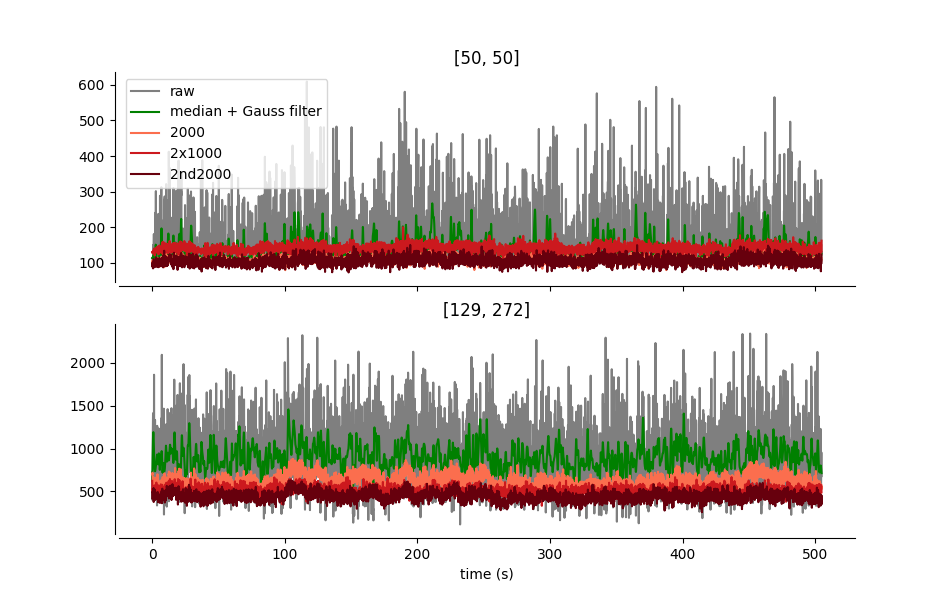

(0.9847443291041906, 0.4329104190695886, 0.3074202229911573, 1.0)
(0.8016147635524797, 0.09950019223375625, 0.1160322952710496, 1.0)
(0.403921568627451, 0.0, 0.05098039215686274, 1.0)
(0.9847443291041906, 0.4329104190695886, 0.3074202229911573, 1.0)
(0.8016147635524797, 0.09950019223375625, 0.1160322952710496, 1.0)
(0.403921568627451, 0.0, 0.05098039215686274, 1.0)


Text(0.5, 0, 'time (s)')

In [28]:
%matplotlib notebook
roi_size = 2
alpha = 1

x = np.arange(4040) / 8

alpha = 1
spine_outward_shift=3

fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(9.5, 6), sharex=True, sharey=False)
for i_ax, (ax, pixel) in enumerate(zip(axs, pixels_noise)):
    roi_signal = np.mean(raw[:, pixel[0]-roi_size:pixel[0]+roi_size, pixel[1]-roi_size:pixel[1]+roi_size], 
                    axis=(1,2))
    ax.plot(x, roi_signal, 'k', label="raw", alpha=0.5)
    ax.plot(x, gaussian_filter1d(medfilt(roi_signal, [5]), sigma=2), 'g', label="median + Gauss filter")
    for i_s, (show_this, d, string) in enumerate(zip(show_signal, denoised, denoised_strings)):
        if show_this:
            color = plt.cm.Reds(0.1+0.9*(i_s+1)/len(show_signal))
            print(color)
            roi_signal = d[:, pixel[0]-roi_size:pixel[0]+roi_size, pixel[1]-roi_size:pixel[1]]
            ax.plot(x, np.mean(roi_signal, axis=(1,2)), color=color, alpha=alpha, label=string)
    ax.set_title(pixel)
    if i_ax == 0:
        ax.legend()
        
    ax.spines['left'].set_position(('outward', spine_outward_shift))  # ('axes', -0.02))  # 'zero'

    # turn off the right spine/ticks
    ax.spines['right'].set_color('none')
    ax.yaxis.tick_left()

    # set the y-spine
    ax.spines['bottom'].set_position(('outward', spine_outward_shift))  # ('axes', -0.02))  # 'zero'

    # turn off the top spine/ticks
    ax.spines['top'].set_color('none')
    ax.xaxis.tick_bottom()
        
ax.set_xlabel("time (s)")
    
# ax.set_xlim([200/8, 800/8])
# ax.set_ylim([0, 3000])
# fig.suptitle("${}^2$ ROI signals".format(roi_size*2+1))